In [3]:
import os
import sys
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


def ensure_project_root_on_path(marker: str = 'datasets', max_depth: int = 6) -> Path:
    current = Path.cwd().resolve()
    for _ in range(max_depth + 1):
        if (current / marker).exists():
            if str(current) not in sys.path:
                sys.path.insert(0, str(current))
            return current
        current = current.parent
    raise ModuleNotFoundError(f"Не удалось найти папку {marker!r} поблизости. Запустите ноутбук из корня проекта или поправьте путь.")


PROJECT_ROOT = ensure_project_root_on_path()
print(f'Project root detected at: {PROJECT_ROOT}')
if 'datasets' in sys.modules:
    mod_file = getattr(sys.modules['datasets'], '__file__', '')
    if mod_file and 'dl-cv-home-test' not in mod_file:
        sys.modules.pop('datasets')
    elif not mod_file:
        sys.modules.pop('datasets')

from datasets.instereo2k import InStereo2KDataset

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

TARGET_HW = (256, 512)
BATCH_SIZE = 2
DEVICE = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


def apply_pair_color_jitter(left: torch.Tensor, right: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    if torch.rand(1).item() < 0.7:
        factor = torch.empty(1).uniform_(0.8, 1.2).item()
        left = TF.adjust_brightness(left, factor)
        right = TF.adjust_brightness(right, factor)
    if torch.rand(1).item() < 0.7:
        factor = torch.empty(1).uniform_(0.8, 1.2).item()
        left = TF.adjust_contrast(left, factor)
        right = TF.adjust_contrast(right, factor)
    if torch.rand(1).item() < 0.4:
        factor = torch.empty(1).uniform_(0.8, 1.2).item()
        left = TF.adjust_saturation(left, factor)
        right = TF.adjust_saturation(right, factor)
    if torch.rand(1).item() < 0.2:
        factor = torch.empty(1).uniform_(-0.04, 0.04).item()
        left = TF.adjust_hue(left, factor)
        right = TF.adjust_hue(right, factor)
    return left.clamp(0.0, 1.0), right.clamp(0.0, 1.0)


def apply_pair_blur(left: torch.Tensor, right: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    if torch.rand(1).item() < 0.25:
        sigma = torch.empty(1).uniform_(0.1, 1.5).item()
        left = TF.gaussian_blur(left, kernel_size=3, sigma=(sigma, sigma))
        right = TF.gaussian_blur(right, kernel_size=3, sigma=(sigma, sigma))
    return left, right


def apply_pair_noise(left: torch.Tensor, right: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    if torch.rand(1).item() < 0.3:
        std = torch.empty(1).uniform_(0.0, 0.02).item()
        noise = torch.randn_like(left) * std
        left = (left + noise).clamp(0.0, 1.0)
        right = (right + noise).clamp(0.0, 1.0)
    return left, right


def make_stereo_transform(train: bool):
    normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)

    def _transform(sample: dict) -> dict:
        sample = sample.copy()
        left = sample['left']
        right = sample['right']
        if train:
            left, right = apply_pair_color_jitter(left, right)
            left, right = apply_pair_blur(left, right)
            left, right = apply_pair_noise(left, right)
        sample['left'] = normalize(left)
        sample['right'] = normalize(right)
        return sample

    return _transform


train_dataset = InStereo2KDataset(
    root_dir=PROJECT_ROOT / 'data' / 'instereo2k_sample',
    split='train',
    val_ratio=0.1,
    load_disp=True,
    disp_side='left',
    disp_divisor=100.0,
    resize_hw=TARGET_HW,
    transform=make_stereo_transform(train=True),
)

val_dataset = InStereo2KDataset(
    root_dir=PROJECT_ROOT / 'data' / 'instereo2k_sample',
    split='val',
    val_ratio=0.1,
    load_disp=True,
    disp_side='left',
    disp_divisor=100.0,
    resize_hw=TARGET_HW,
    transform=make_stereo_transform(train=False),
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

models_dir = PROJECT_ROOT / 'models'
models_dir.mkdir(exist_ok=True)
print('Models dir :', models_dir)


Project root detected at: /Users/olgashalashova/dl-cv-home-test
Models dir : /Users/olgashalashova/dl-cv-home-test/models


## StereoUNet

In [23]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout: float | None = None):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout2d(dropout))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class StereoUNet(nn.Module):
    def __init__(self, in_ch=6, out_ch=1):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 64, dropout=0.1)
        self.enc2 = ConvBlock(64, 128, dropout=0.1)
        self.enc3 = ConvBlock(128, 256, dropout=0.2)
        self.enc4 = ConvBlock(256, 512, dropout=0.3)

        self.pool = nn.MaxPool2d(2)

        self.dec3 = ConvBlock(256 + 512, 256, dropout=0.2)
        self.dec2 = ConvBlock(128 + 256, 128, dropout=0.1)
        self.dec1 = ConvBlock(64 + 128, 64, dropout=0.1)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.refine = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=4, dilation=4),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, out_ch, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.up(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        d1 = self.refine(d1)

        out = self.final(d1)
        return out


In [4]:

import math
import torch.nn.functional as F

SMOOTH_LAMBDA = 0.1


def masked_smooth_l1(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor, beta: float = 0.1) -> torch.Tensor:
    loss_map = F.smooth_l1_loss(pred, target, reduction='none', beta=beta)
    masked_loss = loss_map * mask
    denom = mask.sum().clamp(min=1.0)
    return masked_loss.sum() / denom


def edge_aware_smoothness(pred: torch.Tensor, ref_img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    grad_disp_x = pred[:, :, :, 1:] - pred[:, :, :, :-1]
    grad_disp_y = pred[:, :, 1:, :] - pred[:, :, :-1, :]

    grad_img_x = ref_img[:, :, :, 1:] - ref_img[:, :, :, :-1]
    grad_img_y = ref_img[:, :, 1:, :] - ref_img[:, :, :-1, :]

    weight_x = torch.exp(-torch.mean(torch.abs(grad_img_x), dim=1, keepdim=True))
    weight_y = torch.exp(-torch.mean(torch.abs(grad_img_y), dim=1, keepdim=True))

    mask_x = mask[:, :, :, 1:] * mask[:, :, :, :-1]
    mask_y = mask[:, :, 1:, :] * mask[:, :, :-1, :]

    smooth_x = (weight_x * torch.abs(grad_disp_x) * mask_x).sum()
    smooth_y = (weight_y * torch.abs(grad_disp_y) * mask_y).sum()

    denom = mask_x.sum() + mask_y.sum()
    return (smooth_x + smooth_y) / denom.clamp(min=1.0)


def train_stereo_model(
    model: torch.nn.Module,
    train_loader,
    val_loader,
    optimizer,
    num_epochs: int = 10,
    scheduler=None,
    grad_clip: float | None = 1.0,
    model_name: str = 'stereo_model.pth',
    loss_fn=None,
):
    save_path = models_dir / model_name
    best_val_loss = float('inf')
    history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_main = train_smooth = 0.0
        train_pixels = 0.0

        for batch in train_loader:
            left = batch['left'].to(DEVICE)
            right = batch['right'].to(DEVICE)
            gt_disp = batch['disp'].unsqueeze(1).to(DEVICE)
            mask = batch.get('mask')
            if mask is None:
                valid_mask = (gt_disp > 0).float()
            else:
                valid_mask = mask.unsqueeze(1).to(DEVICE).float()

            pred = model(torch.cat([left, right], dim=1))
            if pred.shape[-2:] != gt_disp.shape[-2:]:
                pred = F.interpolate(pred, size=gt_disp.shape[-2:], mode='bilinear', align_corners=False)

            if loss_fn is None:
                main_loss = masked_smooth_l1(pred, gt_disp, valid_mask)
                smooth_loss = edge_aware_smoothness(pred, left, valid_mask)
                loss = main_loss + SMOOTH_LAMBDA * smooth_loss
            else:
                loss = loss_fn(pred, gt_disp, valid_mask)
                main_loss = loss
                smooth_loss = torch.zeros(1, device=loss.device, dtype=loss.dtype)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            pixels = valid_mask.sum().item()
            train_pixels += pixels
            train_main += main_loss.item() * pixels
            train_smooth += smooth_loss.item() * pixels

        train_main /= max(train_pixels, 1.0)
        train_smooth /= max(train_pixels, 1.0)
        train_total = train_main + SMOOTH_LAMBDA * train_smooth

        model.eval()
        val_main = val_smooth = 0.0
        val_pixels = 0.0
        mae_sum = rmse_sum = 0.0

        with torch.no_grad():
            for batch in val_loader:
                left = batch['left'].to(DEVICE)
                right = batch['right'].to(DEVICE)
                gt_disp = batch['disp'].unsqueeze(1).to(DEVICE)
                mask = batch.get('mask')
                if mask is None:
                    valid_mask = (gt_disp > 0).float()
                else:
                    valid_mask = mask.unsqueeze(1).to(DEVICE).float()

                pred = model(torch.cat([left, right], dim=1))
                if pred.shape[-2:] != gt_disp.shape[-2:]:
                    pred = F.interpolate(pred, size=gt_disp.shape[-2:], mode='bilinear', align_corners=False)

                if loss_fn is None:
                    main_loss = masked_smooth_l1(pred, gt_disp, valid_mask)
                    smooth_loss = edge_aware_smoothness(pred, left, valid_mask)
                    loss = main_loss + SMOOTH_LAMBDA * smooth_loss
                else:
                    loss = loss_fn(pred, gt_disp, valid_mask)
                    main_loss = loss
                    smooth_loss = torch.zeros(1, device=loss.device, dtype=loss.dtype)

                pixels = valid_mask.sum().item()
                val_pixels += pixels
                val_main += main_loss.item() * pixels
                val_smooth += smooth_loss.item() * pixels

                diff = (pred - gt_disp) * valid_mask
                mae_sum += diff.abs().sum().item()
                rmse_sum += diff.pow(2).sum().item()

        val_main /= max(val_pixels, 1.0)
        val_smooth /= max(val_pixels, 1.0)
        val_total = val_main + SMOOTH_LAMBDA * val_smooth
        mae = mae_sum / max(val_pixels, 1.0)
        rmse = math.sqrt(rmse_sum / max(val_pixels, 1.0))

        if scheduler is not None:
            scheduler.step(val_total)

        print(f"train_total={train_total:.4f} | val_total={val_total:.4f} | val_mae={mae:.4f} | val_rmse={rmse:.4f}")
        history.append({
            'epoch': epoch + 1,
            'train_total': train_total,
            'val_total': val_total,
            'val_mae': mae,
            'val_rmse': rmse,
        })

        if val_total < best_val_loss:
            best_val_loss = val_total
            torch.save(model.state_dict(), save_path)
            print(f"Saved best checkpoint → {save_path}")

    print(f"Best val loss: {best_val_loss:.4f}")
    return history



In [9]:
unet_model = StereoUNet().to(DEVICE)
unet_optimizer = optim.AdamW(unet_model.parameters(), lr=1e-3, weight_decay=1e-4)
unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, mode='min', factor=0.5, patience=3)

unet_history = train_stereo_model(
    unet_model,
    train_loader,
    val_loader,
    unet_optimizer,
    num_epochs=15,
    scheduler=unet_scheduler,
    grad_clip=1.0,
    model_name='stereo_unet_best.pth',
)


Epoch 1/15
train_total=10.6091 | val_total=7.8361 | val_mae=7.8661 | val_rmse=9.9316
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_best.pth
Epoch 2/15
train_total=9.0813 | val_total=9.3553 | val_mae=9.3846 | val_rmse=11.2932
Epoch 3/15
train_total=9.1567 | val_total=9.1970 | val_mae=9.2340 | val_rmse=12.2874
Epoch 4/15
train_total=8.8542 | val_total=7.4733 | val_mae=7.5118 | val_rmse=10.3000
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_best.pth
Epoch 5/15
train_total=8.3171 | val_total=7.5336 | val_mae=7.5697 | val_rmse=10.3504
Epoch 6/15
train_total=8.5846 | val_total=6.7412 | val_mae=6.7704 | val_rmse=8.9973
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_best.pth
Epoch 7/15
train_total=8.2362 | val_total=7.0212 | val_mae=7.0574 | val_rmse=9.6879
Epoch 8/15
train_total=8.2864 | val_total=6.7027 | val_mae=6.7379 | val_rmse=9.1742
Saved best checkpoint → /Users/olgashalashova/dl-cv-h

Loaded checkpoint: /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_best.pth
Stereo UNet → MAE 31.766 px | RMSE 34.675 px


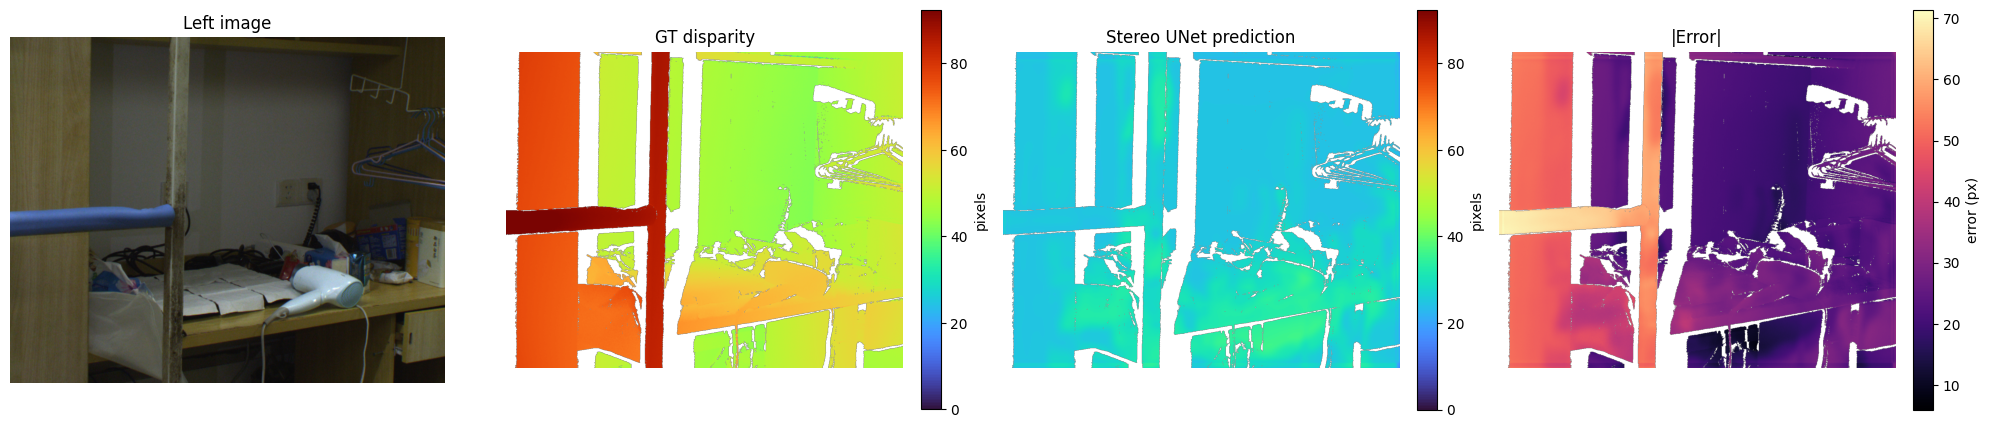

In [11]:

from typing import Callable
from PIL import Image

EVAL_TRANSFORM = transforms.Compose([
    transforms.Resize(TARGET_HW),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


def load_model_from_checkpoint(
    ckpt_path: Path,
    model_factory: Callable[[], torch.nn.Module] | None = None,
    device: torch.device | str = DEVICE,
) -> torch.nn.Module:
    """Создаёт модель локально или загружает готовый модуль из папки `models`."""
    ckpt_path = Path(ckpt_path)
    if not ckpt_path.exists():
        raise FileNotFoundError(f'Checkpoint {ckpt_path} не найден')

    device = torch.device(device) if not isinstance(device, torch.device) else device

    if model_factory is not None:
        model = model_factory().to(device)
        checkpoint = torch.load(ckpt_path, map_location=device)
        if isinstance(checkpoint, dict):
            state = checkpoint.get('state_dict', checkpoint)
            if all(k.startswith('module.') for k in state.keys()):
                state = {k.replace('module.', '', 1): v for k, v in state.items()}
            model.load_state_dict(state, strict=False)
        elif isinstance(checkpoint, torch.nn.Module):
            model = checkpoint.to(device)
        else:
            raise ValueError(f'Неподдерживаемый формат чекпоинта: {type(checkpoint)}')
    else:
        try:
            model = torch.jit.load(str(ckpt_path), map_location=device)
        except (RuntimeError, ValueError, FileNotFoundError):
            checkpoint = torch.load(ckpt_path, map_location=device)
            if isinstance(checkpoint, torch.nn.Module):
                model = checkpoint.to(device)
            elif isinstance(checkpoint, dict):
                raise ValueError('Для state_dict требуется передать model_factory')
            else:
                raise ValueError(f'Неподдерживаемый формат чекпоинта: {type(checkpoint)}')

    return model.eval()


def visualize_model(
    model_factory: Callable[[], torch.nn.Module] | None,
    ckpt_name: str,
    title: str,
    scene_id: str = '000401',
):
    ckpt_path = models_dir / ckpt_name
    model = load_model_from_checkpoint(ckpt_path, model_factory=model_factory, device=DEVICE)
    print('Loaded checkpoint:', ckpt_path)

    left_path = PROJECT_ROOT / 'data' / 'instereo2k_sample' / scene_id / 'left.png'
    right_path = PROJECT_ROOT / 'data' / 'instereo2k_sample' / scene_id / 'right.png'
    gt_path = PROJECT_ROOT / 'data' / 'instereo2k_sample' / scene_id / 'left_disp.png'

    left_img = Image.open(left_path).convert('RGB')
    right_img = Image.open(right_path).convert('RGB')
    gt_disp = np.array(Image.open(gt_path), dtype=np.float32) / 100.0
    mask = np.isfinite(gt_disp) & (gt_disp > 0)

    with torch.no_grad():
        left = EVAL_TRANSFORM(left_img).unsqueeze(0).to(DEVICE)
        right = EVAL_TRANSFORM(right_img).unsqueeze(0).to(DEVICE)
        pred = model(torch.cat([left, right], dim=1))
        pred = torch.relu(pred)
        pred = F.interpolate(pred, size=(left_img.height, left_img.width), mode='bilinear', align_corners=False)
        pred = pred.clamp(min=0.0)

    pred_disp = pred.squeeze().cpu().numpy()
    mae = np.mean(np.abs(pred_disp - gt_disp)[mask]) if mask.any() else float('nan')
    rmse = np.sqrt(np.mean(((pred_disp - gt_disp) ** 2)[mask])) if mask.any() else float('nan')
    print(f'{title} → MAE {mae:.3f} px | RMSE {rmse:.3f} px')

    vmax = np.percentile(gt_disp[mask], 99) if mask.any() else gt_disp.max()
    error_map = np.abs(pred_disp - gt_disp)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(left_img)
    axs[0].set_title('Left image')
    axs[0].axis('off')

    im1 = axs[1].imshow(np.ma.masked_where(~mask, gt_disp), cmap='turbo', vmin=0, vmax=vmax)
    axs[1].set_title('GT disparity')
    axs[1].axis('off')

    im2 = axs[2].imshow(np.ma.masked_where(~mask, pred_disp), cmap='turbo', vmin=0, vmax=vmax)
    axs[2].set_title(f'{title} prediction')
    axs[2].axis('off')

    im3 = axs[3].imshow(np.ma.masked_where(~mask, error_map), cmap='magma')
    axs[3].set_title('|Error|')
    axs[3].axis('off')

    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='pixels')
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04, label='pixels')
    fig.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04, label='error (px)')
    plt.tight_layout()
    plt.show()


visualize_model(lambda: StereoUNet(), 'stereo_unet_best.pth', 'Stereo UNet', scene_id = '000478')


## MobileStereoNet

In [22]:
import torch.nn as nn


class DSConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, kernel_size=k, stride=s, padding=p, groups=in_ch, bias=False)
        self.pw = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        return self.act(x)


class MobileStereoNet(nn.Module):
    def __init__(self, in_ch=6, base=24):
        super().__init__()
        self.enc1 = nn.Sequential(DSConv(in_ch, base), DSConv(base, base))
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(DSConv(base, base * 2), DSConv(base * 2, base * 2))
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = nn.Sequential(DSConv(base * 2, base * 4), DSConv(base * 4, base * 4))

        self.bottleneck = nn.Sequential(DSConv(base * 4, base * 6), DSConv(base * 6, base * 6))

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(DSConv(base * 6 + base * 4, base * 3), DSConv(base * 3, base * 3))
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Sequential(DSConv(base * 3 + base * 2, base * 2), DSConv(base * 2, base * 2))
        self.head = nn.Conv2d(base * 2, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)                       # [B, base, H, W]
        e2 = self.enc2(self.pool1(e1))          # [B, base*2, H/2, W/2]
        e3 = self.enc3(self.pool2(e2))          # [B, base*4, H/4, W/4]

        b = self.bottleneck(e3)                 # [B, base*6, H/4, W/4]

        # concat на уровне e3
        d2 = self.dec2(torch.cat([b, e3], dim=1))  # [B, base*3, H/4, W/4]
        d2 = self.up2(d2)                          # [B, base*3, H/2, W/2]

        d1 = self.dec1(torch.cat([d2, e2], dim=1)) # [B, base*2, H/2, W/2]
        d1 = self.up1(d1)                          # [B, base*2, H, W]

        return self.head(d1)  


In [59]:
mobile_model = MobileStereoNet().to(DEVICE)
mobile_optimizer = optim.AdamW(mobile_model.parameters(), lr=2e-3, weight_decay=1e-4)
mobile_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mobile_optimizer, mode='min', factor=0.5, patience=3, min_lr=5e-5)

mobile_history = train_stereo_model(
    mobile_model,
    train_loader,
    val_loader,
    mobile_optimizer,
    num_epochs=12,
    scheduler=mobile_scheduler,
    grad_clip=0.5,
    model_name='mobile_stereo_best.pth',
)


Epoch 1/12
train_total=25.7740 | val_total=18.8110 | val_mae=18.8467 | val_rmse=21.0565
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/mobile_stereo_best.pth
Epoch 2/12
train_total=10.0624 | val_total=6.9525 | val_mae=6.9911 | val_rmse=9.2651
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/mobile_stereo_best.pth
Epoch 3/12
train_total=7.5364 | val_total=6.2273 | val_mae=6.2618 | val_rmse=8.3849
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/mobile_stereo_best.pth
Epoch 4/12
train_total=7.3187 | val_total=6.2734 | val_mae=6.3111 | val_rmse=8.6303
Epoch 5/12
train_total=7.1664 | val_total=6.3282 | val_mae=6.3597 | val_rmse=8.2522
Epoch 6/12
train_total=6.9946 | val_total=6.1038 | val_mae=6.1377 | val_rmse=8.1187
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/mobile_stereo_best.pth
Epoch 7/12
train_total=6.8803 | val_total=6.3077 | val_mae=6.3395 | val_rmse=8.2914
Epoch 8/12
train_total=6.8731 | val_tot

Loaded checkpoint: /Users/olgashalashova/dl-cv-home-test/models/mobile_stereo_best.pth
Mobile StereoNet → MAE 30.034 px | RMSE 32.754 px


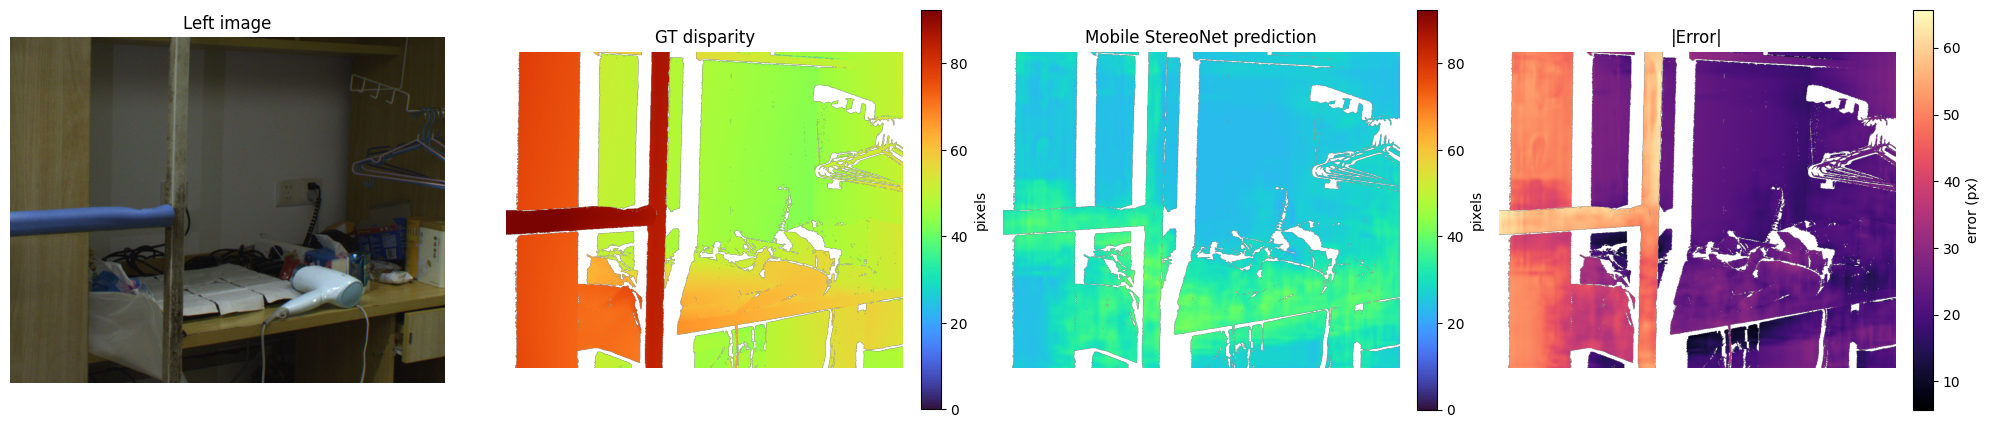

In [18]:
visualize_model(lambda: MobileStereoNet(), 'mobile_stereo_best.pth', 'Mobile StereoNet', scene_id= '000478' )


## UNet + чистый SSIM loss

In [6]:

# 8. Дополнительные loss-функции для UNet-экспериментов

def ssim_loss_only(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor, beta: float = 0.1) -> torch.Tensor:
    if not mask.any():
        return F.smooth_l1_loss(pred, target, beta=beta)
    mask_bool = mask.bool()
    C1, C2 = 0.01 ** 2, 0.03 ** 2
    pad = 5
    mu_p = F.avg_pool2d(pred, 11, 1, pad)
    mu_t = F.avg_pool2d(target, 11, 1, pad)
    sigma_p = F.avg_pool2d(pred * pred, 11, 1, pad) - mu_p * mu_p
    sigma_t = F.avg_pool2d(target * target, 11, 1, pad) - mu_t * mu_t
    sigma_pt = F.avg_pool2d(pred * target, 11, 1, pad) - mu_p * mu_t
    ssim = ((2 * mu_p * mu_t + C1) * (2 * sigma_pt + C2)) / ((mu_p ** 2 + mu_t ** 2 + C1) * (sigma_p + sigma_t + C2))
    loss_map = (1.0 - ssim.clamp(0, 1))
    return loss_map[mask_bool.expand_as(loss_map)].mean()

def hybrid_ssim_smooth(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor, beta: float = 0.1, alpha: float = 0.6) -> torch.Tensor:
    smooth = masked_smooth_l1(pred, target, mask, beta=beta)
    ssim = ssim_loss_only(pred, target, mask, beta=beta)
    return alpha * smooth + (1.0 - alpha) * ssim



In [6]:

# 9. UNet + чистый SSIM loss
unet_ssim_model = StereoUNet().to(DEVICE)
unet_ssim_optimizer = optim.AdamW(unet_ssim_model.parameters(), lr=1e-3, weight_decay=1e-4)
unet_ssim_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_ssim_optimizer, mode='min', factor=0.5, patience=3)

unet_ssim_history = train_stereo_model(
    unet_ssim_model,
    train_loader,
    val_loader,
    unet_ssim_optimizer,
    num_epochs=10,
    scheduler=unet_ssim_scheduler,
    grad_clip=1.0,
    model_name='stereo_unet_ssim_best.pth',
    loss_fn=ssim_loss_only,
)



Epoch 1/10


/Users/olgashalashova/dl-cv-home-test/datasets/instereo2k.py:18: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  return torch.from_numpy(arr).float().div_(255.0)


train_total=0.8150 | val_total=0.7924 | val_mae=9.6362 | val_rmse=11.6954
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_ssim_best.pth
Epoch 2/10
train_total=0.7723 | val_total=0.7695 | val_mae=7.7384 | val_rmse=10.4046
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_ssim_best.pth
Epoch 3/10
train_total=0.7550 | val_total=0.7598 | val_mae=7.8635 | val_rmse=10.0862
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_ssim_best.pth
Epoch 4/10
train_total=0.7527 | val_total=0.7637 | val_mae=7.8690 | val_rmse=10.4155
Epoch 5/10
train_total=0.7478 | val_total=0.7482 | val_mae=7.2088 | val_rmse=9.6007
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_ssim_best.pth
Epoch 6/10
train_total=0.7373 | val_total=0.7411 | val_mae=7.6152 | val_rmse=10.3241
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_ssim_best.pth
Epoch 7/10
train_total=0.73

Loaded checkpoint: /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_ssim_best.pth
Stereo UNet (SSIM) → MAE 4.899 px | RMSE 6.461 px


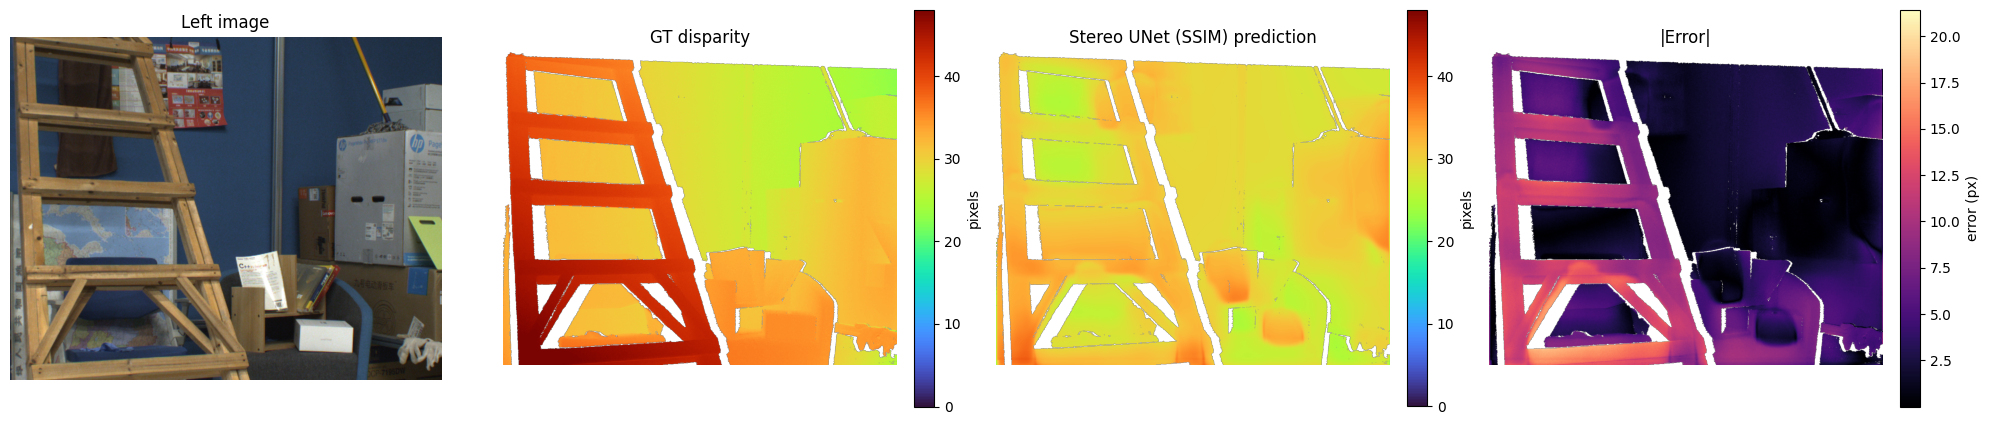

In [23]:

visualize_model(
    lambda: StereoUNet(),
    'stereo_unet_ssim_best.pth',
    'Stereo UNet (SSIM)',
    scene_id = '000401' 
)



## UNet + комбинированный SSIM + SmoothL1 loss

In [24]:

# 10. UNet + комбинированный SSIM + SmoothL1 loss
unet_hybrid_model = StereoUNet().to(DEVICE)
unet_hybrid_optimizer = optim.AdamW(unet_hybrid_model.parameters(), lr=1e-3, weight_decay=1e-4)
unet_hybrid_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(unet_hybrid_optimizer, mode='min', factor=0.5, patience=3)

unet_hybrid_history = train_stereo_model(
    unet_hybrid_model,
    train_loader,
    val_loader,
    unet_hybrid_optimizer,
    num_epochs=10,
    scheduler=unet_hybrid_scheduler,
    grad_clip=1.0,
    model_name='stereo_unet_hybrid_best.pth',
    loss_fn=lambda pred, gt, mask: hybrid_ssim_smooth(pred, gt, mask, beta=0.1, alpha=0.6),
)



Epoch 1/10
train_total=7.1779 | val_total=5.3158 | val_mae=8.3349 | val_rmse=10.6806
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_hybrid_best.pth
Epoch 2/10
train_total=5.9674 | val_total=5.0192 | val_mae=7.8487 | val_rmse=10.4414
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_hybrid_best.pth
Epoch 3/10
train_total=5.5387 | val_total=5.0886 | val_mae=7.9530 | val_rmse=10.0303
Epoch 4/10
train_total=5.5379 | val_total=4.4263 | val_mae=6.8561 | val_rmse=9.1298
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_hybrid_best.pth
Epoch 5/10
train_total=5.6067 | val_total=5.1639 | val_mae=8.0781 | val_rmse=9.9404
Epoch 6/10
train_total=5.2466 | val_total=4.6067 | val_mae=7.1596 | val_rmse=9.6889
Epoch 7/10
train_total=5.2830 | val_total=4.3182 | val_mae=6.6779 | val_rmse=9.1142
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_hybrid_best.pth
Epoch 8/10
train_tota

Loaded checkpoint: /Users/olgashalashova/dl-cv-home-test/models/stereo_unet_hybrid_best.pth
Stereo UNet (Hybrid) → MAE 5.894 px | RMSE 7.908 px


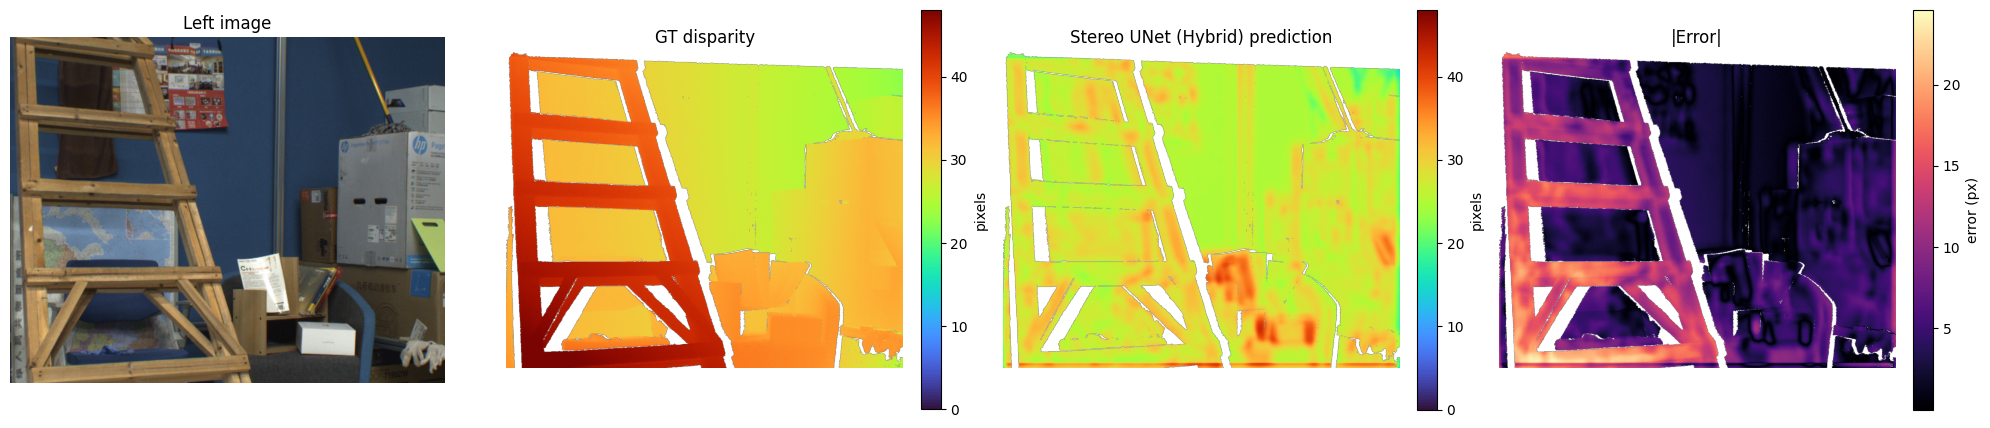

In [25]:

visualize_model(
    lambda: StereoUNet(),
    'stereo_unet_hybrid_best.pth',
    'Stereo UNet (Hybrid)',
)



## ANet с Dropout + комбинированный loss

In [ ]:
def boss_loss(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor, beta: float = 0.1, alpha: float = 0.6) -> torch.Tensor:
    smooth = masked_smooth_l1(pred, target, mask, beta=beta)
    ssim = ssim_loss_only(pred, target, mask, beta=beta)
    return alpha * smooth + (1.0 - alpha) * ssim

In [9]:
class ANet(nn.Module):
    def __init__(self, in_ch=6, out_ch=1, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout2d(dropout)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )

        self.final = nn.ConvTranspose2d(64, out_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.drop1(x)
        e2 = self.enc2(x)
        e3 = self.enc3(e2)
        d2 = self.dec2(e3)
        d1 = self.dec1(d2)
        out = self.final(d1)
        return out


In [11]:
anet_model = ANet().to(DEVICE)

anet_optimizer = optim.AdamW(anet_model.parameters(), lr=5e-4, weight_decay=5e-4)
anet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(anet_optimizer, mode='min', factor=0.5, patience=3)

anet_history = train_stereo_model(
    anet_model,
    train_loader,
    val_loader,
    anet_optimizer,
    num_epochs=15,
    scheduler=anet_scheduler,
    grad_clip=1.0,
    model_name='anet_best.pth',
    loss_fn=boss_loss,
)


Epoch 1/15
train_total=8.0307 | val_total=5.2719 | val_mae=8.2106 | val_rmse=10.9248
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/anet_best.pth
Epoch 2/15
train_total=6.7625 | val_total=5.0286 | val_mae=7.8137 | val_rmse=10.6276
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/anet_best.pth
Epoch 3/15
train_total=6.6455 | val_total=4.7400 | val_mae=7.3341 | val_rmse=10.0938
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/anet_best.pth
Epoch 4/15
train_total=6.5294 | val_total=4.9991 | val_mae=7.7625 | val_rmse=10.0179
Epoch 5/15
train_total=6.3142 | val_total=4.9259 | val_mae=7.6414 | val_rmse=9.7809
Epoch 6/15
train_total=6.6130 | val_total=4.4792 | val_mae=6.9069 | val_rmse=9.2382
Saved best checkpoint → /Users/olgashalashova/dl-cv-home-test/models/anet_best.pth
Epoch 7/15
train_total=6.2675 | val_total=5.3498 | val_mae=8.3629 | val_rmse=10.2573
Epoch 8/15
train_total=6.1960 | val_total=4.3365 | val_mae=6.6635 | val_rms

Loaded checkpoint: /Users/olgashalashova/dl-cv-home-test/models/anet_best.pth
AnetNet (Hybrid) → MAE 4.974 px | RMSE 6.481 px


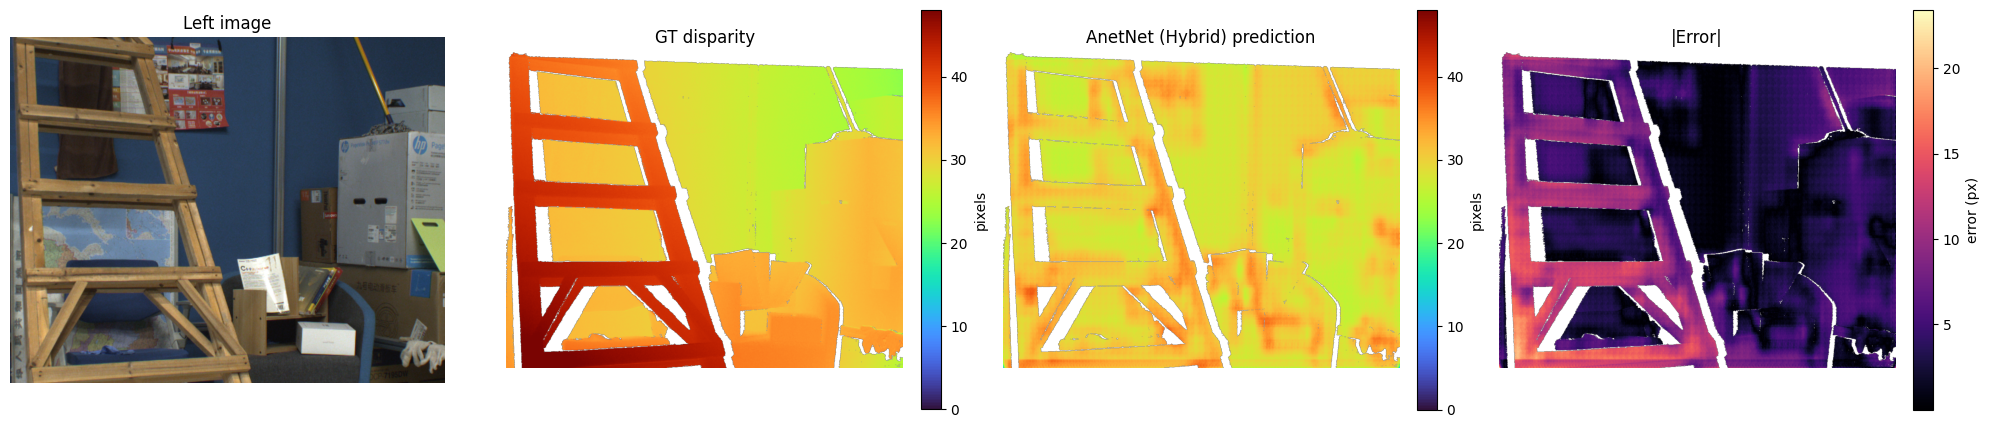

In [18]:

visualize_model(
    lambda: ANet(),
    'anet_best.pth',
    'AnetNet (Hybrid)',
)


## Runtime & Complexity Benchmarks
Добавили вспомогательные утилиты, чтобы сравнить модели по числу параметров, FLOPs и задержке инференса на входе `1×6×{TARGET_HW[0]}×{TARGET_HW[1]}`.


In [19]:

import time
from typing import Callable, Dict, List


def _sync_device(tensor: torch.Tensor) -> None:
    device = tensor.device
    if device.type == 'cuda':
        torch.cuda.synchronize(device)
    elif device.type == 'mps' and hasattr(torch, 'mps'):
        torch.mps.synchronize()


def measure_latency(model: torch.nn.Module, sample: torch.Tensor, *, warmup: int = 10, runs: int = 30) -> float:
    model.eval()
    with torch.no_grad():
        for _ in range(max(warmup, 0)):
            _ = model(sample)
        if runs <= 0:
            return 0.0
        _sync_device(sample)
        start = time.perf_counter()
        for _ in range(runs):
            _ = model(sample)
            _sync_device(sample)
        elapsed = time.perf_counter() - start
    return (elapsed / runs) * 1000.0


def _accumulate_conv2d_flops(module: torch.nn.Conv2d, inputs, output, acc: Dict[str, float]):
    x = inputs[0]
    y = output if isinstance(output, torch.Tensor) else output[0]
    batch = x.shape[0]
    out_channels = module.out_channels
    kernel_h, kernel_w = module.kernel_size
    groups = module.groups
    in_channels = module.in_channels // groups
    out_h, out_w = y.shape[-2:]
    flops = 2.0 * batch * out_channels * out_h * out_w * in_channels * kernel_h * kernel_w
    acc['flops'] += flops


def _accumulate_linear_flops(module: torch.nn.Linear, inputs, output, acc: Dict[str, float]):
    x = inputs[0]
    batch = x.shape[0]
    in_features = module.in_features
    out_features = module.out_features
    flops = 2.0 * batch * in_features * out_features
    acc['flops'] += flops


def compute_flops(model: torch.nn.Module, sample: torch.Tensor) -> float:
    acc = {'flops': 0.0}
    handles: List = []
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            handles.append(module.register_forward_hook(lambda m, inp, out, acc=acc: _accumulate_conv2d_flops(m, inp, out, acc)))
        elif isinstance(module, torch.nn.Linear):
            handles.append(module.register_forward_hook(lambda m, inp, out, acc=acc: _accumulate_linear_flops(m, inp, out, acc)))
    model.eval()
    with torch.no_grad():
        _ = model(sample)
    for handle in handles:
        handle.remove()
    return acc['flops']


def benchmark_model(
    model_factory: Callable[[], torch.nn.Module] | None,
    ckpt_name: str,
    title: str,
    *,
    input_hw: tuple[int, int] = TARGET_HW,
    warmup: int = 10,
    runs: int = 30,
) -> Dict[str, float]:
    ckpt_path = models_dir / ckpt_name
    model = load_model_from_checkpoint(ckpt_path, model_factory=model_factory, device=DEVICE)

    params = sum(p.numel() for p in model.parameters())

    dummy_left = torch.randn(1, 3, input_hw[0], input_hw[1], device=DEVICE)
    dummy_right = torch.randn(1, 3, input_hw[0], input_hw[1], device=DEVICE)
    sample = torch.cat([dummy_left, dummy_right], dim=1)

    flops = compute_flops(model, sample)
    latency_ms = measure_latency(model, sample, warmup=warmup, runs=runs)

    result = {
        'model': title,
        'params': params,
        'flops': flops,
        'latency_ms': latency_ms,
    }
    print(f"{title}: {params / 1e6:.2f}M params | {flops / 1e9:.2f} GFLOPs | {latency_ms:.2f} ms")
    return result


In [26]:

benchmarks = [
    benchmark_model(StereoUNet, 'stereo_unet_best.pth', 'Stereo UNet'),
    benchmark_model(MobileStereoNet, 'mobile_stereo_best.pth', 'Mobile StereoNet'),
    benchmark_model(StereoUNet, 'stereo_unet_ssim_best.pth', 'Stereo UNet (SSIM)'),
    benchmark_model(StereoUNet, 'stereo_unet_hybrid_best.pth', 'Stereo UNet (Hybrid)'),
    benchmark_model(ANet, 'anet_best.pth', 'ANet (Hybrid)'),
]

print("\nСводка по эффективности:")
for item in benchmarks:
    print(f"- {item['model']}: {item['params'] / 1e6:.2f}M params | {item['flops'] / 1e9:.2f} GFLOPs | {item['latency_ms']:.2f} ms")


Stereo UNet: 7.90M params | 199.03 GFLOPs | 40.76 ms
Mobile StereoNet: 0.09M params | 2.43 GFLOPs | 4.73 ms
Stereo UNet (SSIM): 7.90M params | 199.03 GFLOPs | 40.68 ms
Stereo UNet (Hybrid): 7.90M params | 199.03 GFLOPs | 40.92 ms
ANet (Hybrid): 1.05M params | 3.65 GFLOPs | 7.77 ms

Сводка по эффективности:
- Stereo UNet: 7.90M params | 199.03 GFLOPs | 40.76 ms
- Mobile StereoNet: 0.09M params | 2.43 GFLOPs | 4.73 ms
- Stereo UNet (SSIM): 7.90M params | 199.03 GFLOPs | 40.68 ms
- Stereo UNet (Hybrid): 7.90M params | 199.03 GFLOPs | 40.92 ms
- ANet (Hybrid): 1.05M params | 3.65 GFLOPs | 7.77 ms
